In [1]:
# Initial Setup

train=True
Epochs=30
preload=False
hough=False
rams=False
dynAug=False
depth = 6
chan = 64
ir = 1.1
rand_sv = 42
ds = 'MIX'
zone = 'CUP'
cup = True
mix = True
dri = False
rim = False

In [2]:
# Import all the necessary libraries

import tensorflow as tf
import os
import glob
from datetime import datetime
import warnings
warnings.simplefilter('ignore')
import scipy as sp
import scipy.ndimage
import numpy as np
import pandas as pd
import skimage
import skimage.exposure
import skimage.transform
import skimage.measure
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import h5py
from tqdm import tqdm_notebook
from IPython.display import display
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers as layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, ZeroPadding2D, Input, Embedding, LSTM, Lambda, UpSampling2D, concatenate, Conv2DTranspose
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam, Adagrad
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import math

In [3]:
from tensorflow import keras

In [4]:
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)
def log_dice_loss(y_true, y_pred):
    return -K.log(dice_coef(y_true, y_pred))

# Computes mean Intersection-over-Union (IOU) for two arrays of binary images.

def iou_loss_core(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true,-1) + K.sum(y_pred,-1) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

In [5]:
# helper function to increase the brightness
# hue, saturation, value

def modify_brightness_p(img, p=1.2):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 1.0/p
    v[v > lim] = 1.0
    v[v <= lim] *= p

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR).clip(min=0)
    return img

In [6]:
def index512_resize(index,top):
    index=index*top/512
    return int(index)

In [7]:
# helper code to shuffle instead of random shuffle 

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [8]:
K.set_floatx('float32')

In [9]:
#load the data

h5f2 = h5py.File(os.path.join(os.path.dirname(os.getcwd()), r'C:\Users\Ranjith ch\Desktop\code\glucoma\model\data', 'DRISHTI_GS.hdf5'), 'r')

In [10]:
# DRISHTI Dataset
# step1: prepare the data for our model injection

Xori= np.asarray(h5f2['DRISHTI-GS/orig/images'])
disc_locations = np.asarray( h5f2['DRISHTI-GS/512 px/disc_locations'])
FC = np.asarray(h5f2['DRISHTI-GS/512 px/file_codes'] ) 
indDRI = np.arange(0,Xori.shape[0])
bsqside=np.maximum((disc_locations[:,3]-disc_locations[:,1]),(disc_locations[:,2]-disc_locations[:,0]))
isize=Xori.shape[1]

if (cup):
  
  Yf = np.asarray(h5f2['DRISHTI-GS/512 px/cup'])
 
  Xc = [Xori[i][index512_resize(disc_locations[i][0],isize):index512_resize(disc_locations[i][0]+bsqside[i],isize), index512_resize(disc_locations[i][1],isize):index512_resize(disc_locations[i][1]+bsqside[i],isize)] 
                   for i in range(len(Xori))]

  Yc=[Yf[i][disc_locations[i][0]:disc_locations[i][0]+bsqside[i], disc_locations[i][1]:disc_locations[i][1]+bsqside[i]] 
                   for i in range(len(Xori))]

else:
  Yf =np.asarray( h5f2['DRISHTI-GS/512 px/disc'])
  
  Xc = [Xori[i][index512_resize(50,isize):index512_resize(462,isize), index512_resize(50,isize):index512_resize(462,isize)] 
                   for i in range(len(Xori))]

  Yc=[Yf[i][50:462,50:462] 
                   for i in range(len(Xori))]

X=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST) for img in Xc]
X=np.asarray(X) 
am=np.amax(X)
X=X.astype(np.float32)/am 
print(np.amax(X),np.amin(X))

Y=[cv2.resize(img, (128, 128),interpolation=cv2.INTER_NEAREST)[..., None] for img in Yc]
Y=np.asarray(Y) 
ym=np.amax(Y) 
Yf=Y/ym
#get binary mask
Yb=(Y>0.5).astype(np.float32) 

print(np.amax(Yf),np.amin(Yf))
print(X.shape)

1.0 0.0
1.0 0.0
(50, 128, 128, 3)


In [11]:
# step2: Create train and test set by combining datasets

rng = np.random.RandomState(rand_sv)

#DRISHTI
X_train1t, X_test1t, Y_train1t, Y_test1t, F_train1t, F_test1t ,ind_train1, ind_test1= train_test_split( X, Yb, FC, indDRI,test_size=0.25,random_state=rng)

X_test_dri=np.copy(X_test1t)
Y_test_dri=np.copy(Y_test1t)
F_test_dri=np.copy(F_test1t)


if(dri or mix):
  X_train1=np.concatenate([X_train1t,X_train1t])
  X_train1=np.concatenate([X_train1,X_train1t])
  X_test1=np.concatenate([X_test1t,X_test1t])
  X_test1=np.concatenate([X_test1,X_test1t])

  Y_train1=np.concatenate([Y_train1t,Y_train1t])
  Y_train1=np.concatenate([Y_train1,Y_train1t])
  Y_test1=np.concatenate([Y_test1t,Y_test1t])
  Y_test1=np.concatenate([Y_test1,Y_test1t])


if(dri):
  X_train1=np.concatenate([X_train1,X_train1])
  Y_train1=np.concatenate([Y_train1,Y_train1])

X_train1=np.asarray(X_train1)
Y_train1=np.asarray(Y_train1)
X_test=np.asarray(X_test1)
Y_test=np.asarray(Y_test1)

X_train=np.copy(X_train1)
Y_train=np.copy(Y_train1)

size=X_train1.shape[0]

X_traine=np.empty((20*size, 128, 128, 3),dtype=np.float32)
Y_traine=np.empty((20*size, 128, 128, 1),dtype=np.float32) 

In [12]:
# Step3: Preprocessing step for Cup Segmentation
# Perform CLAHE on each image

for i in range(16):
  X_traine[i*size:(i+1)*size]=X_train1
  Y_traine[i*size:(i+1)*size]=Y_train1
  
base= 16*size

for j in tqdm_notebook(range(X_train1.shape[0])):
  X_traine[base]=skimage.exposure.equalize_adapthist(X_train1[j], clip_limit=0.04)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=skimage.exposure.equalize_adapthist(X_train1[j], clip_limit=0.02)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=modify_brightness_p(X_train1[j],0.9)
  Y_traine[base]=Y_train1[j]
  base+=1
  X_traine[base]=modify_brightness_p(X_train1[j],1.1)
  Y_traine[base]=Y_train1[j]
  base+=1
  
X_testc=np.copy(X_test)
Y_testc=np.copy(Y_test)

sizev=X_testc.shape[0]

X_teste=np.empty((20*sizev, 128, 128, 3),dtype=np.float32)
Y_teste=np.empty((20*sizev, 128, 128, 1),dtype=np.float32)

for i in range(8):
  X_teste[i*sizev:(i+1)*sizev]=X_testc
  Y_teste[i*sizev:(i+1)*sizev]=Y_testc
  
basev= 8*sizev

for j in tqdm_notebook(range(X_testc.shape[0])):
  X_teste[basev]=skimage.exposure.equalize_adapthist(X_testc[j], clip_limit=0.04)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=skimage.exposure.equalize_adapthist(X_testc[j], clip_limit=0.02)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=modify_brightness_p(X_testc[j],0.9)
  Y_teste[basev]=Y_testc[j]
  basev+=1
  X_teste[basev]=modify_brightness_p(X_testc[j],1.1)
  Y_teste[basev]=Y_testc[j]
  basev+=1

  0%|          | 0/111 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

In [13]:
# step4: Shuffle the dataset

X_trains,Y_trains = unison_shuffled_copies(X_traine, Y_traine)
X_tests,Y_tests = unison_shuffled_copies(X_teste, Y_teste)

In [14]:

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x

In [15]:

from keras.layers import Conv2D, Input, AvgPool2D

In [16]:

def model_build_func(input_shape,n_labels=1, using_deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision:
        model = Model(input=inputs, output=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    return model

In [17]:

seed = rand_sv
batch_s = 120

In [18]:
# helper function for ipython notebook

cp_callbacks = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma\cnn\plus_last_check_point.hdf5'), verbose=1, save_best_only=True,save_weights_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, min_lr=2e-4)

In [19]:
input_shape = (128, 128, 3)

In [20]:
model = model_build_func(input_shape)


In [21]:
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 32  512        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=.001, ),
    loss=log_dice_loss, metrics=[dice_coef]
    )

In [23]:
# Model Training Step 

if(train):
    history = model.fit(
    X_trains,Y_trains,
    epochs=10,
    batch_size=128,
    steps_per_epoch=35,
    validation_data = (X_tests,Y_tests),
    callbacks=[cp_callbacks,reduce_lr],
    verbose=1
  )

# save the trained model weights
model.save_weights(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma\cnn\plus_cup_last_check_point.hdf5'), overwrite=True)

Epoch 1/10
35/35 [==============================] - ETA: 0s - loss: 0.7505 - dice_coef: 0.4727  
Epoch 00001: val_loss improved from inf to 0.91938, saving model to C:\Users\Ranjith ch\Desktop\code\glucoma\cnn\plus_last_check_point.hdf5
35/35 [==============================] - 3059s 87s/step - loss: 0.7505 - dice_coef: 0.4727 - val_loss: 0.9194 - val_dice_coef: 0.4003 - lr: 0.0010
Epoch 2/10
35/35 [==============================] - ETA: 0s - loss: 0.6657 - dice_coef: 0.5140  
Epoch 00002: val_loss did not improve from 0.91938
35/35 [==============================] - 3114s 91s/step - loss: 0.6657 - dice_coef: 0.5140 - val_loss: 1.4971 - val_dice_coef: 0.2235 - lr: 0.0010
Epoch 3/10
35/35 [==============================] - ETA: 0s - loss: 0.2726 - dice_coef: 0.7642  
Epoch 00003: val_loss did not improve from 0.91938
35/35 [==============================] - 3301s 95s/step - loss: 0.2726 - dice_coef: 0.7642 - val_loss: 1.2228 - val_dice_coef: 0.2963 - lr: 0.0010
Epoch 4/10
35/35 [========

In [24]:
result = model.evaluate(X_tests[0:700,:,:,:],Y_tests[0:700,:,:,:])
print("log dice loss for test set = ", result[0], ' ||| ',"dice coeffecient (accuracy) for test set = ", result[1])

22/22 [==============================] - 38s 2s/step - loss: 0.5947 - dice_coef: 0.5526
log dice loss for test set =  0.5946863293647766  |||  dice coeffecient (accuracy) for test set =  0.552623987197876


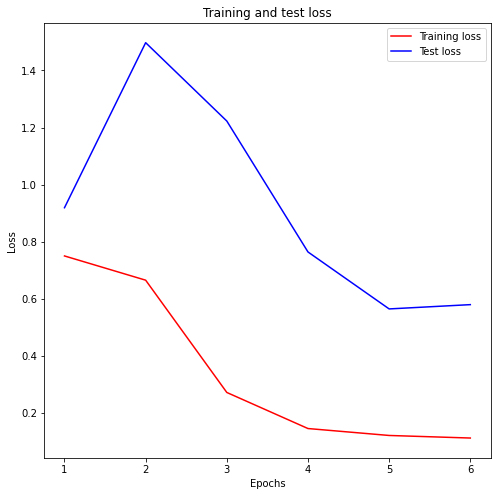

In [25]:

if(train):
  loss = history.history['loss']
  val_loss=history.history['val_loss']
  acc=history.history['dice_coef']
  epochs = range(1, len(loss) + 1)
  plt.figure(figsize=(8, 8))
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Test loss')
  plt.title('Training and test loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  #plt.savefig(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma','loss'+'model1_cup'+'.png'),dpi=600)

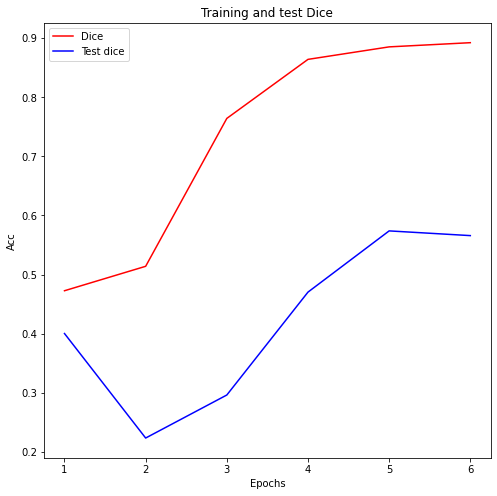

In [26]:
# plot train and test dice coeffecient (accuracy)
if(train):
  loss = history.history['loss']
  acc=history.history['dice_coef']
  val_acc=history.history['val_dice_coef']
  epochs = range(1, len(acc) + 1)
  plt.figure(figsize=(8, 8))
  plt.plot(epochs, acc, 'r', label='Dice')
  plt.plot(epochs, val_acc, 'b', label='Test dice')
  plt.title('Training and test Dice')
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.legend()
  #plt.savefig(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma','hist'+'model1_cup'+'.png'),dpi=600)

In [27]:
# Defining metrics again

smooth=1e-07
def np_dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( (2. * intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) + smooth) )
    
def np_iou(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return ( ( intersection + smooth) / 
             (np.sum(y_true_f) + np.sum(y_pred_f) - intersection + smooth) )   

In [28]:
test_s=int(X_test_dri.shape[0])
test_s

13

In [29]:
from skimage.morphology import dilation
from skimage.feature import canny
from skimage import color

(13, 128, 128, 3)


  0%|          | 0/13 [00:00<?, ?it/s]

Dice mean= 0.7085434  Std= 0.06408561  best= 0.7968188  worst= 0.58968973
IOU mean= 0.5524212  Std= 0.07629144  best= 0.66226  worst= 0.41812763
image #2
0.7968188
image #9
0.58968973


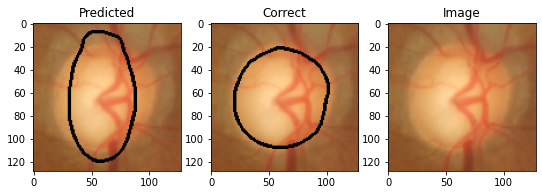

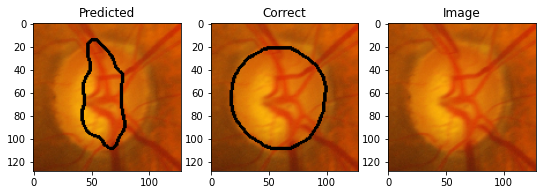

In [30]:
#%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)

batch_X = X_test_dri[0:test_s]
batch_y = Y_test_dri[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    img = X_test_dri[i]
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in [ix_best,ix_worst]:
    print('image #{}'.format(i))
    img = X_test_dri[i]
    pred = predv1[i]
    corr = corrv[i]
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    edgesp = canny(pred)
    edgesp=1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(img*edgesp)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    edgesc = canny(corr)
    edgesc=1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(img*edgesc)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(img)
    ax.set_title('Image')
    #fig.savefig(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma','img_drishti'+str(j)+'model1_cup'+'.png'),dpi=600)
    j+=1

(13, 128, 128, 3)


  0%|          | 0/13 [00:00<?, ?it/s]

image #0
0.78555506


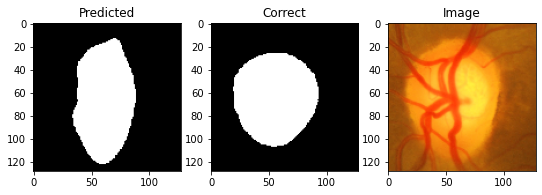

image #1
0.6848506


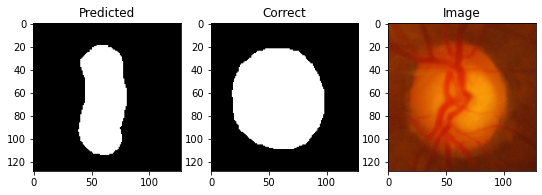

image #2
0.7968188


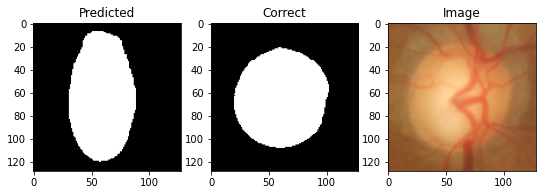

image #3
0.6885982


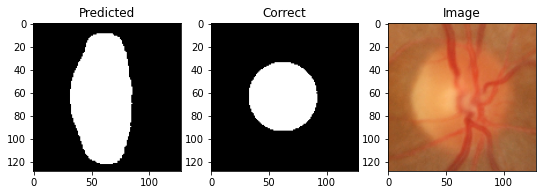

image #4
0.6450654


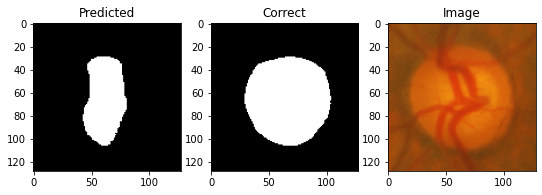

image #5
0.7256949


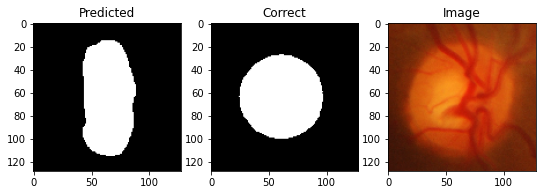

image #6
0.6380368


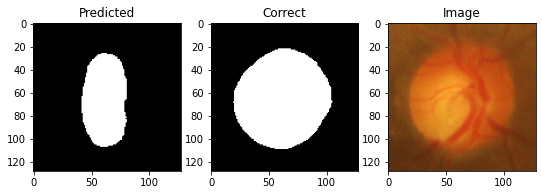

image #7
0.7774364


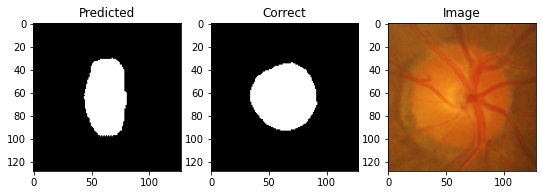

image #8
0.74126047


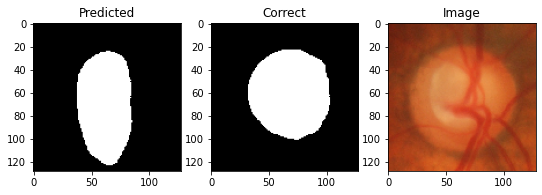

image #9
0.58968973


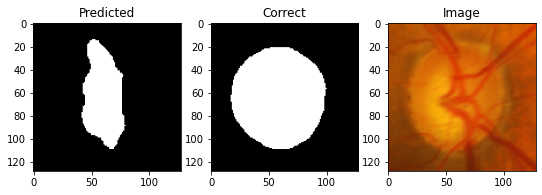

image #10
0.6381934


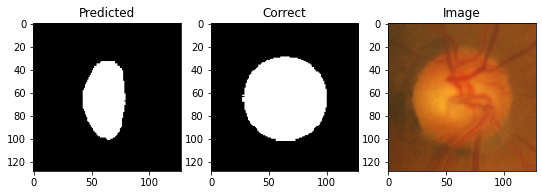

image #11
0.7265306


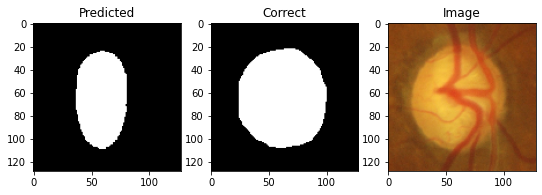

image #12
0.7733333


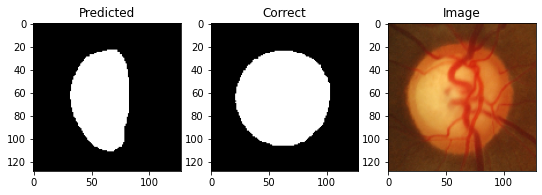

In [31]:
#%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)

batch_X = X_test_dri[0:test_s]
batch_y = Y_test_dri[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    img = X_test_dri[i]
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    

j=0
for i in range(test_s):
    print('image #{}'.format(i))
    img = X_test_dri[i]
    pred = predv1[i]
    corr = corrv[i]
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(pred, cmap=plt.cm.Greys_r)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(corr, cmap=plt.cm.Greys_r)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    #ax.imshow(img)
    ax.imshow(img)
    ax.set_title('Image')
    plt.show()
    j+=1

(13, 128, 128, 3)


  0%|          | 0/13 [00:00<?, ?it/s]

Dice mean= 0.7085434  Std= 0.06408561  best= 0.7968188  worst= 0.58968973
IOU mean= 0.5524212  Std= 0.07629144  best= 0.66226  worst= 0.41812763
image #0
0.78555506
image #1
0.6848506
image #2
0.7968188
image #3
0.6885982
image #4
0.6450654
image #5
0.7256949
image #6
0.6380368
image #7
0.7774364
image #8
0.74126047
image #9
0.58968973
image #10
0.6381934
image #11
0.7265306
image #12
0.7733333


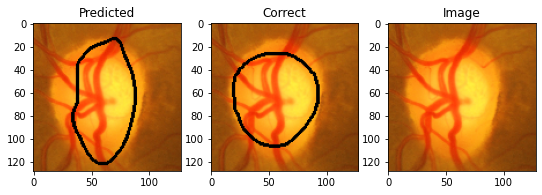

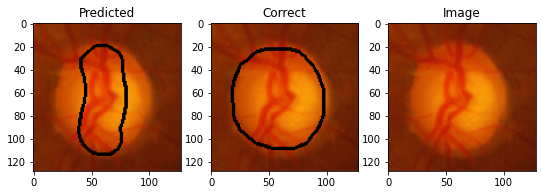

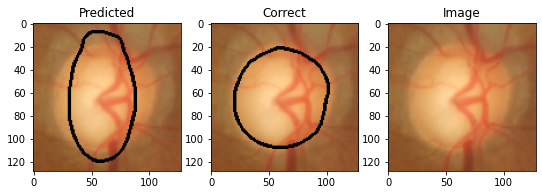

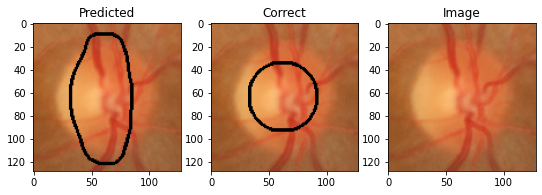

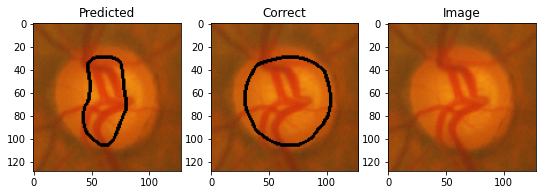

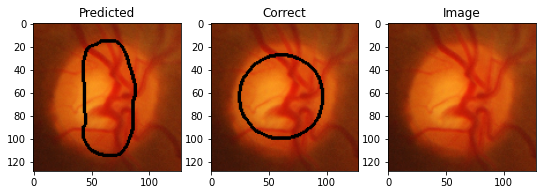

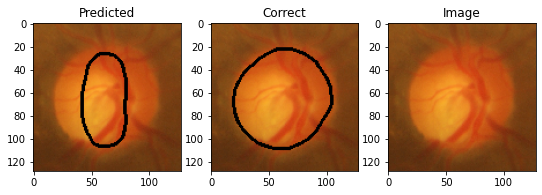

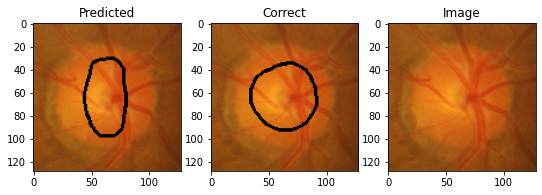

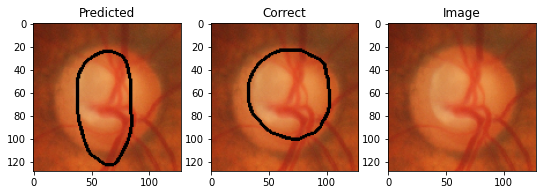

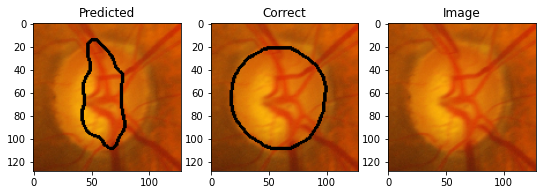

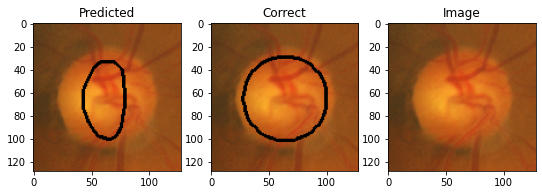

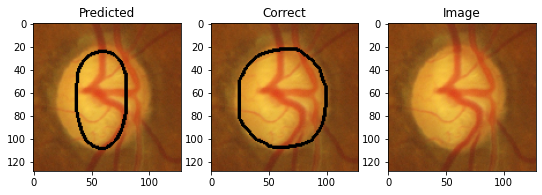

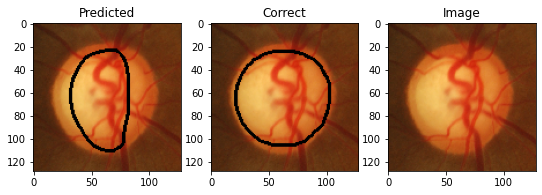

In [32]:
#%%time
pred_dice=np.empty((test_s), dtype=np.float32)
pred_iou=np.empty((test_s), dtype=np.float32)

batch_X = X_test_dri[0:test_s]
batch_y = Y_test_dri[0:test_s]
print (batch_X.shape)
    
predv = (model.predict(batch_X,batch_size=test_s)[...,0]>0.5).astype(np.float32)
corrv= (batch_y)[ ..., 0].astype(np.float32)
predv1=predv.copy()

for i in tqdm_notebook(range(predv.shape[0])):
    img = X_test_dri[i]
    pred = predv[i]
    corr = corrv[i]
    label_pc = skimage.measure.label(pred, connectivity=pred.ndim)
    props_pc = skimage.measure.regionprops(label_pc)
    sz=len(props_pc)
    if(sz)!=0:
      areap=[props_pc[i].area for i in range(sz)]
      k=np.argmax(areap)
      predv1[i]=np.equal(label_pc,k+1).astype(int).astype(np.float32)
    pred1= predv1[i]
    cur_dice = np_dice_coef(pred1, corr)
    cur_iou = np_iou(pred1,corr)
    pred_dice[i]=(cur_dice)
    pred_iou[i]=cur_iou
    
    
d_worst=np.amin(pred_dice)
d_best=np.amax(pred_dice)
d_mean=np.mean(pred_dice)
d_std=np.std(pred_dice)
print("Dice mean=",d_mean, " Std=",d_std, " best=",d_best," worst=",d_worst)

i_worst=np.amin(pred_iou)
i_best=np.amax(pred_iou)
i_mean=np.mean(pred_iou)
i_std=np.std(pred_iou)
print("IOU mean=",i_mean, " Std=",i_std, " best=",i_best," worst=",i_worst)

ix_best=np.argmax(pred_dice)
ix_worst=np.argmin(pred_dice)

j=0
for i in range(test_s):
    print('image #{}'.format(i))
    img = X_test_dri[i]
    pred = predv1[i]
    corr = corrv[i]
    print(pred_dice[i])
    fig = plt.figure(figsize=(9, 4))
    ax = fig.add_subplot(1, 3, 1)
    edgesp = canny(pred)
    edgesp=1.0-dilation(edgesp)
    edgesp = color.gray2rgb(1.0*edgesp)
    ax.imshow(img*edgesp)
    ax.set_title('Predicted')
    ax = fig.add_subplot(1, 3, 2)
    edgesc = canny(corr)
    edgesc=1.0-dilation(edgesc)
    edgesc = color.gray2rgb(1.0*edgesc)
    ax.imshow(img*edgesc)
    ax.set_title('Correct')
    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(img)
    ax.set_title('Image')
    #fig.savefig(os.path.join(r'C:\Users\Ranjith ch\Desktop\code\glucoma','img_drishti'+str(j)+'model1_cup'+'.png'),dpi=600)
    j+=1